--- Phase 1: Data Loading & Preparation ---
✅ Dataset Loaded: 7043 records


/tmp/ipython-input-2319744337.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
/tmp/ipython-input-2319744337.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Churn'], palette='pastel')


✅ Data Processed & Scaled (80% Train / 20% Test).

--- Phase 2: Visualizing the Problem ---


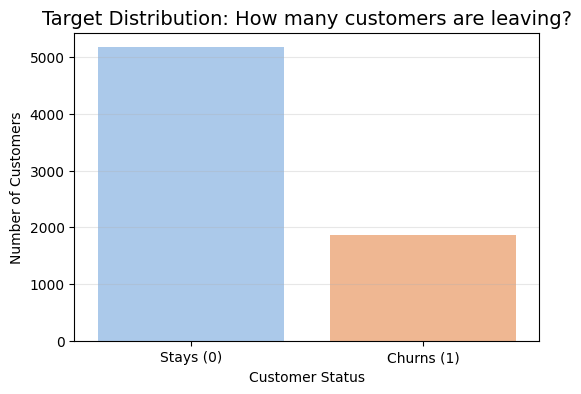

--- Phase 3: What Drives Churn? ---


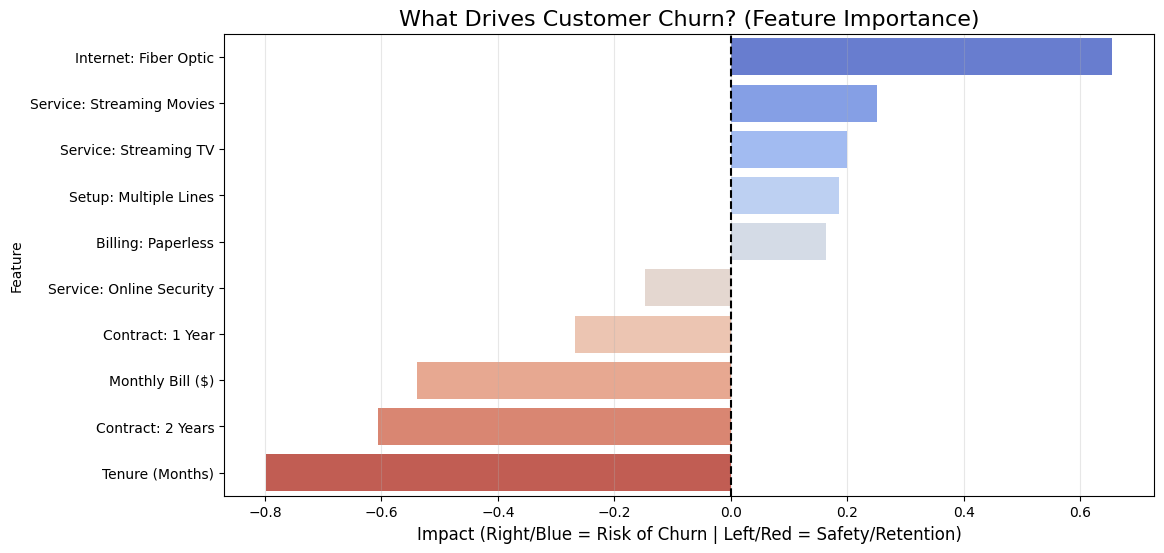


--- Phase 4: Training Candidate Models ---
✅ All Models Trained.

--- Phase 5: Model Leaderboard ---

🏆 Model Accuracy Rankings:
                 Model  Accuracy
0  Logistic Regression  0.819730
1        Decision Tree  0.807665
2        Random Forest  0.792761


/tmp/ipython-input-2319744337.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')


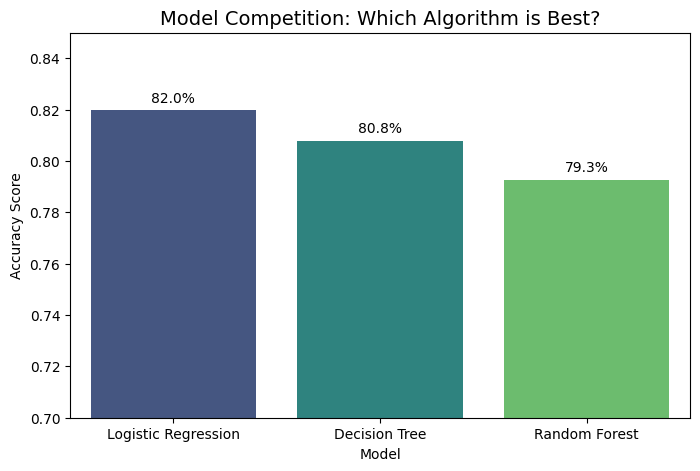


--- Phase 6: Churn Risk Calculator ---
Customer: 2 months | $90.00/mo | Fiber: True | Month-to-month
⚠️ HIGH RISK: 82.0% chance of churning.
------------------------------
Customer: 70 months | $25.00/mo | Fiber: False | Two year
✅ SAFE: Only 11.0% chance of churning.
------------------------------

🏆 WINNER: Logistic Regression with 81.97% Accuracy

--- Technical Report for Logistic Regression ---
              precision    recall  f1-score   support

       Stays       0.86      0.91      0.88      1036
      Churns       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.76      1409
weighted avg       0.81      0.82      0.81      1409



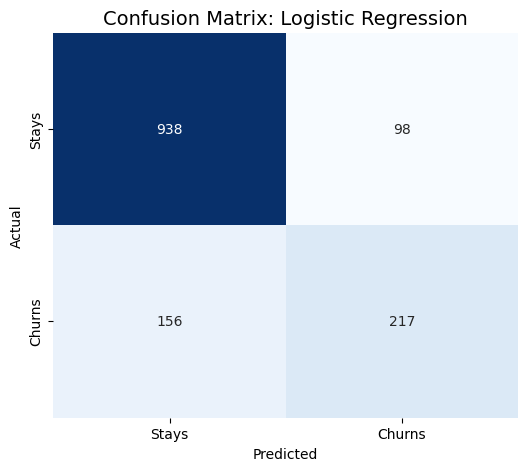

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocessing & Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# PHASE 1: DATA LOADING & PREPARATION
# ==========================================
print("--- Phase 1: Data Loading & Preparation ---")

try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print(f"✅ Dataset Loaded: {len(df)} records")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv'")
    raise

# 1. Clean Numeric Data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# 2. Encode Target (Churn: Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Prepare Features (X) and Target (y)
y = df['Churn']
X = df.drop(['Churn', 'customerID'], axis=1)

# 4. One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# 5. Remove 'TotalCharges' (Redundant with Monthly * Tenure)
X_final = X.drop(['TotalCharges'], axis=1, errors='ignore')

# 6. Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Processed & Scaled (80% Train / 20% Test).\n")

# ==========================================
# PHASE 2: EDA (Chart 1: Distribution)
# ==========================================
print("--- Phase 2: Visualizing the Problem ---")

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Churn'], palette='pastel')
plt.title('Target Distribution: How many customers are leaving?', fontsize=14)
plt.xlabel('Customer Status')
plt.xticks([0, 1], ['Stays (0)', 'Churns (1)'])
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.3)
plt.show()

# ==========================================
# PHASE 3: FEATURE ANALYSIS (Chart 2: Drivers)
# ==========================================
print("--- Phase 3: What Drives Churn? ---")

# Train a temporary model just for interpretation
explainer_model = LogisticRegression(max_iter=1000, random_state=42)
explainer_model.fit(X_train_scaled, y_train)

# Extract and Organize Coefficients
coeffs = pd.DataFrame({
    'Feature': X_final.columns,
    'Score': explainer_model.coef_[0]
})

# Professional Renaming Dictionary
name_mapping = {
    'tenure': 'Tenure (Months)',
    'MonthlyCharges': 'Monthly Bill ($)',
    'InternetService_Fiber optic': 'Internet: Fiber Optic',
    'Contract_Two year': 'Contract: 2 Years',
    'Contract_One year': 'Contract: 1 Year',
    'StreamingMovies_Yes': 'Service: Streaming Movies',
    'StreamingTV_Yes': 'Service: Streaming TV',
    'PaperlessBilling_Yes': 'Billing: Paperless',
    'MultipleLines_Yes': 'Setup: Multiple Lines',
    'OnlineSecurity_Yes': 'Service: Online Security'
}
coeffs['Feature'] = coeffs['Feature'].replace(name_mapping)
coeffs = coeffs.sort_values(by='Score', ascending=False)

# Select Top 5 Risk (Positive) and Top 5 Safety (Negative) Factors
top_risk = coeffs.head(5)
bottom_safe = coeffs.tail(5)
plot_data = pd.concat([top_risk, bottom_safe])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=plot_data, hue='Feature', palette='coolwarm', legend=False)
plt.title('What Drives Customer Churn? (Feature Importance)', fontsize=16)
plt.xlabel('Impact (Right/Blue = Risk of Churn | Left/Red = Safety/Retention)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.show()

# ==========================================
# PHASE 4: MODELING (Training 3 Models)
# ==========================================
print("\n--- Phase 4: Training Candidate Models ---")

# 1. Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

# 2. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print("✅ All Models Trained.\n")

# ==========================================
# PHASE 5: EVALUATION (Chart 3: Comparison)
# ==========================================
print("--- Phase 5: Model Leaderboard ---")

# Calculate Accuracy Scores
log_acc = accuracy_score(y_test, log_pred)
dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [log_acc, dt_acc, rf_acc]
})
results = results.sort_values(by='Accuracy', ascending=False)

# Display Table
print("\n🏆 Model Accuracy Rankings:")
print(results)

# Plot Comparison
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.title('Model Competition: Which Algorithm is Best?', fontsize=14)
plt.ylim(0.70, 0.85)
plt.ylabel('Accuracy Score')

# Add percentage labels
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.1%}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

# ==========================================
# PHASE 6: DEPLOYMENT (The Calculator)
# ==========================================
print("\n--- Phase 6: Churn Risk Calculator ---")

def churn_predictor_tool(tenure, monthly_bill, fiber_optic, contract_type):
    # Setup dummy input
    input_data = pd.DataFrame(np.zeros((1, X_final.shape[1])), columns=X_final.columns)

    # Fill inputs
    if 'tenure' in input_data.columns: input_data['tenure'] = tenure
    if 'MonthlyCharges' in input_data.columns: input_data['MonthlyCharges'] = monthly_bill
    if fiber_optic and 'InternetService_Fiber optic' in input_data.columns:
        input_data['InternetService_Fiber optic'] = 1

    if contract_type == 'Two year' and 'Contract_Two year' in input_data.columns:
        input_data['Contract_Two year'] = 1
    elif contract_type == 'One year' and 'Contract_One year' in input_data.columns:
        input_data['Contract_One year'] = 1

    # Scale and Predict
    input_scaled = scaler.transform(input_data)
    prob = rf_model.predict_proba(input_scaled)[0][1] # Using RF for probability

    print(f"Customer: {tenure} months | ${monthly_bill:.2f}/mo | Fiber: {fiber_optic} | {contract_type}")
    if prob > 0.5:
        print(f"⚠️ HIGH RISK: {prob:.1%} chance of churning.")
    else:
        print(f"✅ SAFE: Only {prob:.1%} chance of churning.")
    print("-" * 30)

# Run Scenarios
churn_predictor_tool(2, 90, True, 'Month-to-month') # Risky
churn_predictor_tool(70, 25, False, 'Two year')     # Safe

# ==========================================
# PHASE 7: CONCLUSION (Chart 4: Confusion Matrix)
# ==========================================
best_model_name = results.iloc[0]['Model']
best_acc = results.iloc[0]['Accuracy']

print(f"\n🏆 WINNER: {best_model_name} with {best_acc:.2%} Accuracy")

# Select Winner's Predictions
if best_model_name == 'Logistic Regression': final_pred = log_pred
elif best_model_name == 'Decision Tree': final_pred = dt_pred
else: final_pred = rf_pred

# Classification Report
print(f"\n--- Technical Report for {best_model_name} ---")
print(classification_report(y_test, final_pred, target_names=['Stays', 'Churns']))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Stays', 'Churns'], yticklabels=['Stays', 'Churns'])
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()